In [1]:
from Data import data_processing as dp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from Fcnn.fcnn_analysis import analyze_fcnn_model
from sklearn.metrics import precision_score, recall_score


In [2]:

X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = dp.get_training_data_fcnn()

In [3]:
# Define the fully connected neural network
class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.output = nn.Linear(64, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)  # Logits (raw scores)
        return x


In [4]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [5]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Initialize the model
input_dim = X_train.shape[1]
output_dim = len(set(y_train))  # Number of classes (e.g., 2 for binary classification)
model = FCNN(input_dim, output_dim)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Create a dictionary to store training metrics
train_metrics = {
    'losses': [],
    'accuracies': [],
    'val_losses': [],
    'val_accuracies': []
}
# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Track metrics
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    # Compute average loss for the epoch
    epoch_loss /= len(train_loader)
    accuracy = correct / total

     # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += y_val.size(0)
            val_correct += (val_predicted == y_val).sum().item()

    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    # Store metrics for visualization
    train_metrics['losses'].append(epoch_loss)
    train_metrics['accuracies'].append(accuracy)
    train_metrics['val_losses'].append(val_loss)
    train_metrics['val_accuracies'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/5, Train Loss: 0.3774, Train Accuracy: 0.8647, Val Loss: 0.1943, Val Accuracy: 0.9320
Epoch 2/5, Train Loss: 0.1209, Train Accuracy: 0.9592, Val Loss: 0.1781, Val Accuracy: 0.9349
Epoch 3/5, Train Loss: 0.0684, Train Accuracy: 0.9783, Val Loss: 0.1956, Val Accuracy: 0.9332
Epoch 4/5, Train Loss: 0.0418, Train Accuracy: 0.9897, Val Loss: 0.2166, Val Accuracy: 0.9291
Epoch 5/5, Train Loss: 0.0269, Train Accuracy: 0.9946, Val Loss: 0.2424, Val Accuracy: 0.9264


In [9]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    test_predictions = predicted.cpu().numpy()
    test_targets = y_test_tensor.cpu().numpy()
    
    test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


Test Set Metrics:
Accuracy: 0.9197
Precision: 0.9201
Recall: 0.9197


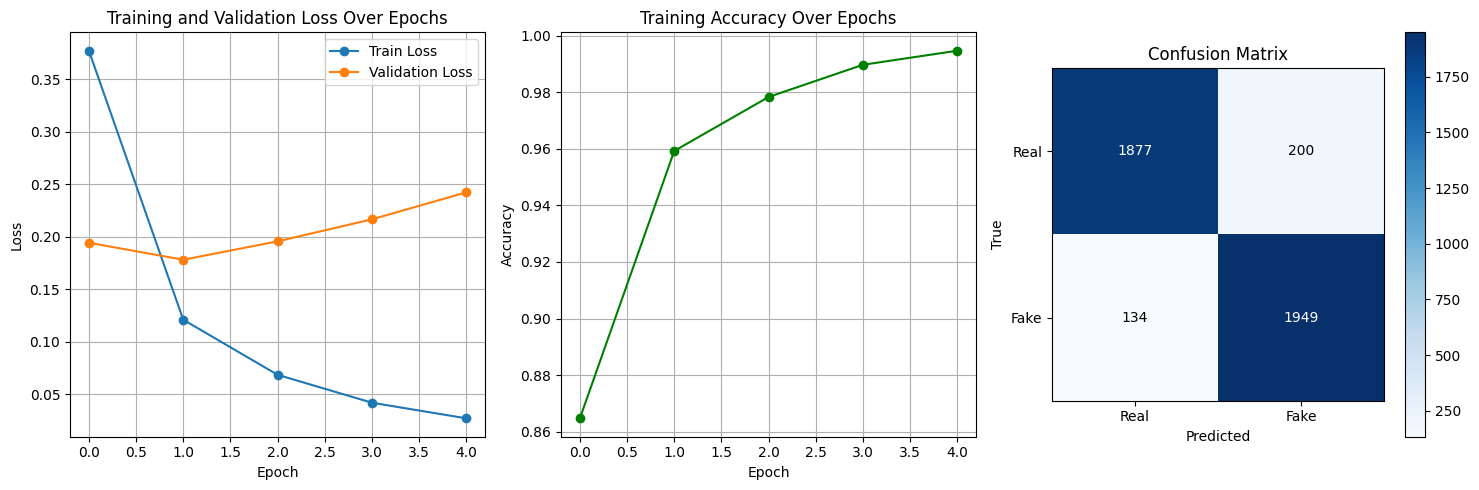

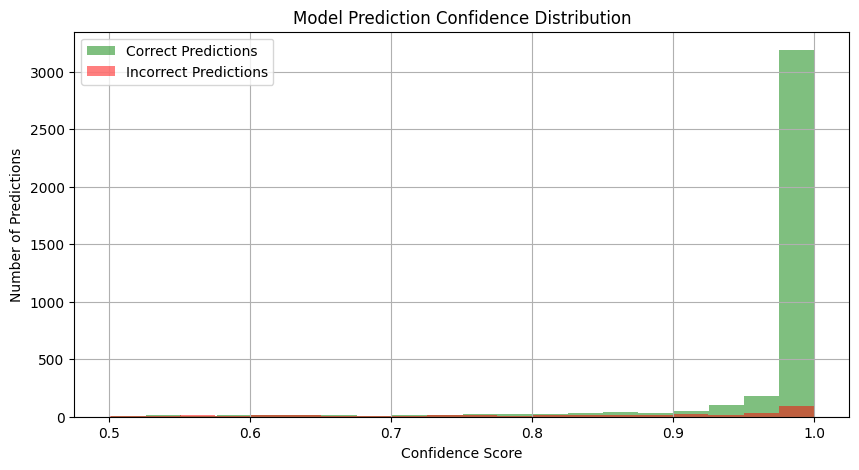


=== Model Performance Summary ===

Confusion Matrix:
                  Predicted
                  Real    Fake
Actual Real:     1877     200
      Fake:     134     1949

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.90      0.92      2077
        Fake       0.91      0.94      0.92      2083

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160


Final Test Accuracy: 0.9197
Average Confidence: 0.9623


In [10]:
analyze_fcnn_model(model, train_metrics, X_test_tensor, y_test_tensor)